# **📄 Document type classification baseline code**
> 문서 타입 분류 대회에 오신 여러분 환영합니다! 🎉     
> 아래 baseline에서는 ResNet 모델을 로드하여, 모델을 학습 및 예측 파일 생성하는 프로세스에 대해 알아보겠습니다.

## Contents
- Prepare Environments
- Import Library & Define Functions
- Hyper-parameters
- Load Data
- Train Model
- Inference & Save File


## 1. Prepare Environments

* 데이터 로드를 위한 구글 드라이브를 마운트합니다.
* 필요한 라이브러리를 설치합니다.

In [1]:
# 필요한 라이브러리를 설치합니다.
# !pip install timm
# !pip install matplotlib
# !pip install seaborn
# !pip install optuna

## 2. Import Library & Define Functions
* 학습 및 추론에 필요한 라이브러리를 로드합니다.
* 학습 및 추론에 필요한 함수와 클래스를 정의합니다.

In [2]:
import os
import time
import random
import copy

import optuna, math
import timm
import torch
import albumentations as A
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from albumentations.pytorch import ToTensorV2
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.cuda.amp import autocast, GradScaler  # Mixed Precision용

from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold

from collections import Counter
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import wandb
from datetime import datetime

# 한글 폰트 설정 (시각화용)
plt.rcParams['font.family'] = ['DejaVu Sans']

In [3]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

In [4]:
# # Focal Loss 구현 (취약 클래스 4,7,14 집중 개선용)
# class FocalLoss(nn.Module):
#     def __init__(self, alpha=None, gamma=2.0, num_classes=17):
#         super(FocalLoss, self).__init__()
#         if alpha is None:
#             alpha = torch.ones(num_classes)
#         else:
#             alpha = torch.tensor(alpha, dtype=torch.float32)
        
#         # 취약 클래스 강화
#         alpha[4] = 2.0
#         alpha[7] = 2.0  
#         alpha[14] = 2.0
        
#         # register_buffer로 디바이스 자동 관리
#         self.register_buffer('alpha', alpha)
#         self.gamma = gamma
        
#     def forward(self, inputs, targets):
#         ce_loss = F.cross_entropy(inputs, targets, reduction='none')
#         pt = torch.exp(-ce_loss)
#         alpha_t = self.alpha[targets]
#         focal_loss = alpha_t * (1 - pt) ** self.gamma * ce_loss
#         return focal_loss.mean()

In [5]:
def mixup_data(x, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).cuda()
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

# 데이터셋 클래스를 정의합니다. (Hard Augmentation 포함)
class ImageDataset(Dataset):
    def __init__(self, data, path, epoch=0, total_epochs=10, is_train=True):
        if isinstance(data, str):
            self.df = pd.read_csv(data).values
        else:
            self.df = data.values
        self.path = path
        self.epoch = epoch
        self.total_epochs = total_epochs
        self.is_train = is_train
        
        # Hard augmentation 확률 계산
        self.p_hard = 0.2 + 0.3 * (epoch / total_epochs) if is_train else 0
        
        # Normal augmentation
        self.normal_aug = A.Compose([
            A.LongestMaxSize(max_size=img_size),
            A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
            A.OneOf([
                A.Rotate(limit=[90,90], p=1.0),
                A.Rotate(limit=[180,180], p=1.0),
                A.Rotate(limit=[270,270], p=1.0),
            ], p=0.6),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.8),
            A.GaussNoise(var_limit=(30.0, 100.0), p=0.7),
            A.HorizontalFlip(p=0.5),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
        ])
        
        # Hard augmentation
        self.hard_aug = A.Compose([
            A.LongestMaxSize(max_size=img_size),
            A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
            A.OneOf([
                A.Rotate(limit=[90,90], p=1.0),
                A.Rotate(limit=[180,180], p=1.0),
                A.Rotate(limit=[270,270], p=1.0),
                A.Rotate(limit=[-15,15], p=1.0),
            ], p=0.8),
            A.OneOf([
                A.MotionBlur(blur_limit=15, p=1.0),
                A.GaussianBlur(blur_limit=15, p=1.0),
            ], p=0.95),
            A.RandomBrightnessContrast(brightness_limit=0.5, contrast_limit=0.5, p=0.9),
            A.GaussNoise(var_limit=(50.0, 150.0), p=0.8),
            A.JpegCompression(quality_lower=70, quality_upper=100, p=0.5),
            A.HorizontalFlip(p=0.5),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)).convert('RGB'))
        
        # 배치별 증강 선택
        if self.is_train and random.random() < self.p_hard:
            img = self.hard_aug(image=img)['image']
        else:
            img = self.normal_aug(image=img)['image']
        
        return img, target

In [6]:
# one epoch 학습을 위한 함수입니다.
def train_one_epoch(loader, model, optimizer, loss_fn, device):
    scaler = GradScaler()  # Mixed Precision용
    model.train()
    train_loss = 0
    preds_list = []
    targets_list = []

    pbar = tqdm(loader)
    for image, targets in pbar:
        image = image.to(device)
        targets = targets.to(device)
        
        # Cutmix/Mixup 적용 (30% 확률)
        if random.random() < 0.3:
            mixed_x, y_a, y_b, lam = mixup_data(image, targets, alpha=1.0)
            with autocast(): preds = model(mixed_x)
            loss = lam * loss_fn(preds, y_a) + (1 - lam) * loss_fn(preds, y_b)
        else:
            with autocast(): preds = model(image)
            loss = loss_fn(preds, targets)

        model.zero_grad(set_to_none=True)

        scaler.scale(loss).backward()  # Mixed Precision용
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer); scaler.update()  # Mixed Precision용

        train_loss += loss.item()
        preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
        targets_list.extend(targets.detach().cpu().numpy())

        pbar.set_description(f"Loss: {loss.item():.4f}")

    train_loss /= len(loader)
    train_acc = accuracy_score(targets_list, preds_list)
    train_f1 = f1_score(targets_list, preds_list, average='macro')

    ret = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "train_f1": train_f1,
    }

    return ret

In [7]:
# validation을 위한 함수 추가
def validate_one_epoch(loader, model, loss_fn, device):
    """
    한 에폭 검증을 수행하는 함수
    - model.eval()로 모델을 평가 모드로 전환
    - torch.no_grad()로 gradient 계산 비활성화하여 메모리 절약
    - 검증 데이터에 대한 loss, accuracy, f1 score 계산
    """
    model.eval()  # 모델을 평가 모드로 전환 (dropout, batchnorm 비활성화)
    val_loss = 0
    preds_list = []
    targets_list = []
    
    with torch.no_grad():  # gradient 계산 비활성화로 메모리 절약
        pbar = tqdm(loader, desc="Validating")
        for image, targets in pbar:
            image = image.to(device)
            targets = targets.to(device)
            
            preds = model(image)  # 모델 예측
            loss = loss_fn(preds, targets)  # 손실 계산
            
            val_loss += loss.item()
            preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())  # 예측 클래스 저장
            targets_list.extend(targets.detach().cpu().numpy())  # 실제 클래스 저장
            
            pbar.set_description(f"Val Loss: {loss.item():.4f}")
    
    val_loss /= len(loader)  # 평균 손실 계산
    val_acc = accuracy_score(targets_list, preds_list)  # 정확도 계산
    val_f1 = f1_score(targets_list, preds_list, average='macro')  # Macro F1 계산 (대회 평가지표)
    
    ret = {
        "val_loss": val_loss,
        "val_acc": val_acc,
        "val_f1": val_f1,
    }
    
    return ret

## 3. Hyper-parameters
* 학습 및 추론에 필요한 하이퍼파라미터들을 정의합니다.

In [ ]:
# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# data config
data_path = '../data/'

# model config
# model_name = 'tf_efficientnetv2_b3' # 'resnet50' 'efficientnet-b0', ...
# model_name = 'swin_base_patch4_window12_384_in22k'
model_name = 'convnext_base_384_in22ft1k'

# training config
img_size = 448
LR = 2e-4
EPOCHS = 50
BATCH_SIZE = 16
num_workers = 8
EMA = True  # Exponential Moving Average 사용 여부

In [9]:
# Optuna를 사용한 하이퍼파라미터 튜닝 (선택적 실행)
USE_OPTUNA = False  # True로 바꾸면 튜닝 실행

if USE_OPTUNA:
    def objective(trial):
        lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
        batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
        
        # 간단한 3-fold CV로 빠른 평가
        skf_simple = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        fold_scores = []
        
        for fold, (train_idx, val_idx) in enumerate(skf_simple.split(train_df, train_df['target'])):
            # 모델 생성
            model = timm.create_model(model_name, pretrained=True, num_classes=17).to(device)
            optimizer = Adam(model.parameters(), lr=lr)
            loss_fn = nn.CrossEntropyLoss()
            
            # 간단한 2 epoch 학습
            for epoch in range(2):
                train_ret = train_one_epoch(trn_loader, model, optimizer, loss_fn, device)
            
            val_ret = validate_one_epoch(val_loader, model, loss_fn, device)
            fold_scores.append(val_ret['val_f1'])
        
        return np.mean(fold_scores)
    
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=10)
    
    # 최적 파라미터 적용
    LR = study.best_params['lr']
    BATCH_SIZE = study.best_params['batch_size']
    print(f"Best params: {study.best_params}")

## 4. Load Data
* 학습, 테스트 데이터셋과 로더를 정의합니다.

In [10]:
# Optuna 튜닝 (선택적 실행)
USE_OPTUNA = False  # True로 바꾸면 튜닝 실행

if USE_OPTUNA:
    # 위의 objective 함수와 study 코드
    pass

# K-Fold 적용

In [11]:
# K-Fold 설정
N_FOLDS = 5  # 5-fold로 설정 (데이터가 적으므로)
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

# 클래스별 최소 샘플 보장 확인
# for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df['target'])):
#     assert len(np.unique(train_df.iloc[val_idx]['target'])) == 17

# 전체 학습 데이터 로드
train_df = pd.read_csv("../data/train.csv")

# K-Fold 결과를 저장할 리스트
fold_results = []
fold_models = []  # 각 fold의 최고 성능 모델을 저장
fold_class_accuracies = [] # 각 fold의 클래스별 정확도 저장

print(f"Starting {N_FOLDS}-Fold Cross Validation...")

# LR = best_params['lr']
# BATCH_SIZE = best_params['batch_size']

# K-Fold Cross Validation 시작
for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df['target'])):
    print(f"\n{'='*50}")
    print(f"FOLD {fold + 1}/{N_FOLDS}")
    print(f"{'='*50}")
    
    current_model = model_name
    
    # 현재 fold의 train/validation 데이터 분할
    train_fold_df = train_df.iloc[train_idx].reset_index(drop=True)
    val_fold_df = train_df.iloc[val_idx].reset_index(drop=True)
    
    # 현재 fold의 Dataset 생성
    trn_dataset = ImageDataset(
        train_fold_df,
        "../data/train/",
        # transform=trn_transform
        epoch=0,  # 현재 epoch 전달
        total_epochs=EPOCHS,
        is_train=True
    )
    
    val_dataset = ImageDataset(
        val_fold_df,
        "../data/train/",
        # transform=tst_transform  # 검증에는 증강 적용 안함
        epoch=0,  # validation은 epoch 관계없음
        total_epochs=EPOCHS,
        is_train=False  # validation이므로 hard augmentation 비활성화
    )
    
    # 현재 fold의 DataLoader 생성
    trn_loader = DataLoader(
        trn_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=False
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    
    print(f"Train samples: {len(trn_dataset)}, Validation samples: {len(val_dataset)}")
    
    # 모델 초기화 (각 fold마다 새로운 모델)
    model = timm.create_model(
        current_model,
        pretrained=True,
        num_classes=17
    ).to(device)
    
    loss_fn = nn.CrossEntropyLoss(label_smoothing=0.02)  # Label Smoothing 적용
    optimizer = Adam(model.parameters(), lr=LR)
    
    # Learning Rate Scheduler 추가
    scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS)
    
    # 현재 fold의 최고 성능 추적
    best_val_f1 = 0.0
    best_model = None
    
    # 현재 fold 학습
    for epoch in range(EPOCHS):
        # Training
        train_ret = train_one_epoch(trn_loader, model, optimizer, loss_fn, device)
        
        # Validation
        val_ret = validate_one_epoch(val_loader, model, loss_fn, device)
        
        # Scheduler step 추가
        scheduler.step()
        
        print(f"Epoch {epoch+1:2d} | "
              f"Train Loss: {train_ret['train_loss']:.4f} | "
              f"Train F1: {train_ret['train_f1']:.4f} | "
              f"Val Loss: {val_ret['val_loss']:.4f} | "
              f"Val F1: {val_ret['val_f1']:.4f}")
        
        # 최고 성능 모델 저장
        if val_ret['val_f1'] > best_val_f1:
            best_val_f1 = val_ret['val_f1']
            best_model = copy.deepcopy(model.state_dict())
            
            # Best 모델 분석
            model.eval()
            val_preds, val_targets = [], []
            with torch.no_grad():
                for image, targets in val_loader:
                    preds = model(image.to(device)).argmax(dim=1)
                    val_preds.extend(preds.cpu().numpy())
                    val_targets.extend(targets.numpy())
            
            # 클래스별 정확도
            fold_class_acc = {}
            for c in range(17):
                mask = np.array(val_targets) == c
                if mask.sum() > 0:
                    fold_class_acc[c] = (np.array(val_preds)[mask] == c).mean()
    
    # 현재 fold 결과 저장
    fold_results.append({
        'fold': fold + 1,
        'best_val_f1': best_val_f1,
        'train_samples': len(trn_dataset),
        'val_samples': len(val_dataset)
    })
    
    fold_models.append(best_model)
    
    print(f"Fold {fold + 1} Best Validation F1: {best_val_f1:.4f}")
    
    fold_class_accuracies.append(fold_class_acc) # 각 fold의 클래스별 정확도 저장

# K-Fold 결과 요약
print(f"\n{'='*60}")
print("K-FOLD CROSS VALIDATION RESULTS")
print(f"{'='*60}")

val_f1_scores = [result['best_val_f1'] for result in fold_results]
mean_f1 = np.mean(val_f1_scores)
std_f1 = np.std(val_f1_scores)

for result in fold_results:
    print(f"Fold {result['fold']}: {result['best_val_f1']:.4f}")

print(f"\nMean CV F1: {mean_f1:.4f} ± {std_f1:.4f}")
print(f"Best single fold: {max(val_f1_scores):.4f}")

Starting 5-Fold Cross Validation...

FOLD 1/5
Train samples: 1256, Validation samples: 314


Val Loss: 0.8181: 100%|██████████| 20/20 [00:05<00:00,  3.85it/s]

Epoch  1 | Train Loss: 1.7584 | Train F1: 0.4273 | Val Loss: 0.7587 | Val F1: 0.6962



Val Loss: 0.8795: 100%|██████████| 20/20 [00:03<00:00,  5.38it/s]

Epoch  2 | Train Loss: 0.8916 | Train F1: 0.6790 | Val Loss: 0.5515 | Val F1: 0.8498



Val Loss: 0.4304: 100%|██████████| 20/20 [00:03<00:00,  5.52it/s]

Epoch  3 | Train Loss: 0.7835 | Train F1: 0.7256 | Val Loss: 0.4670 | Val F1: 0.8609



Val Loss: 0.5251: 100%|██████████| 20/20 [00:03<00:00,  5.38it/s]

Epoch  4 | Train Loss: 0.7275 | Train F1: 0.7334 | Val Loss: 0.4645 | Val F1: 0.8699



Val Loss: 0.5096: 100%|██████████| 20/20 [00:03<00:00,  5.38it/s]

Epoch  5 | Train Loss: 0.5906 | Train F1: 0.7656 | Val Loss: 0.3882 | Val F1: 0.8911



Val Loss: 0.7839: 100%|██████████| 20/20 [00:03<00:00,  5.43it/s]

Epoch  6 | Train Loss: 0.6952 | Train F1: 0.7823 | Val Loss: 0.4213 | Val F1: 0.9067



Val Loss: 0.5517: 100%|██████████| 20/20 [00:03<00:00,  5.56it/s]

Epoch  7 | Train Loss: 0.6605 | Train F1: 0.7577 | Val Loss: 0.3713 | Val F1: 0.9110



Val Loss: 0.4396: 100%|██████████| 20/20 [00:03<00:00,  5.34it/s]

Epoch  8 | Train Loss: 0.5791 | Train F1: 0.7955 | Val Loss: 0.3290 | Val F1: 0.9311



Val Loss: 0.3840: 100%|██████████| 20/20 [00:03<00:00,  5.45it/s]


Epoch  9 | Train Loss: 0.5618 | Train F1: 0.7662 | Val Loss: 0.3256 | Val F1: 0.9304


Val Loss: 0.8244: 100%|██████████| 20/20 [00:03<00:00,  5.51it/s]


Epoch 10 | Train Loss: 0.4948 | Train F1: 0.8467 | Val Loss: 0.4154 | Val F1: 0.8941


Val Loss: 0.5007: 100%|██████████| 20/20 [00:03<00:00,  5.52it/s]


Epoch 11 | Train Loss: 0.4486 | Train F1: 0.8357 | Val Loss: 0.3440 | Val F1: 0.9288


Val Loss: 0.3205: 100%|██████████| 20/20 [00:03<00:00,  5.25it/s]


Epoch 12 | Train Loss: 0.4828 | Train F1: 0.8474 | Val Loss: 0.3586 | Val F1: 0.9081


Val Loss: 0.3378: 100%|██████████| 20/20 [00:03<00:00,  5.07it/s]


Epoch 13 | Train Loss: 0.4566 | Train F1: 0.8443 | Val Loss: 0.3524 | Val F1: 0.9298


Val Loss: 0.3996: 100%|██████████| 20/20 [00:03<00:00,  5.49it/s]

Epoch 14 | Train Loss: 0.4993 | Train F1: 0.8227 | Val Loss: 0.3465 | Val F1: 0.9422



Val Loss: 0.5825: 100%|██████████| 20/20 [00:03<00:00,  5.34it/s]


Epoch 15 | Train Loss: 0.5041 | Train F1: 0.8082 | Val Loss: 0.3464 | Val F1: 0.9204


Val Loss: 0.2994: 100%|██████████| 20/20 [00:03<00:00,  5.34it/s]

Epoch 16 | Train Loss: 0.4342 | Train F1: 0.8366 | Val Loss: 0.3192 | Val F1: 0.9547



Val Loss: 0.3748: 100%|██████████| 20/20 [00:03<00:00,  5.43it/s]


Epoch 17 | Train Loss: 0.4111 | Train F1: 0.8762 | Val Loss: 0.2776 | Val F1: 0.9516


Val Loss: 0.7558: 100%|██████████| 20/20 [00:03<00:00,  5.39it/s]


Epoch 18 | Train Loss: 0.4821 | Train F1: 0.7522 | Val Loss: 0.3164 | Val F1: 0.9496


Val Loss: 0.3610: 100%|██████████| 20/20 [00:03<00:00,  5.22it/s]

Epoch 19 | Train Loss: 0.3833 | Train F1: 0.8932 | Val Loss: 0.2945 | Val F1: 0.9603



Val Loss: 0.4762: 100%|██████████| 20/20 [00:03<00:00,  5.38it/s]


Epoch 20 | Train Loss: 0.3749 | Train F1: 0.8703 | Val Loss: 0.3112 | Val F1: 0.9507


Val Loss: 0.1752: 100%|██████████| 20/20 [00:03<00:00,  5.32it/s]


Epoch 21 | Train Loss: 0.4071 | Train F1: 0.8762 | Val Loss: 0.3359 | Val F1: 0.9504


Val Loss: 0.2685: 100%|██████████| 20/20 [00:03<00:00,  5.40it/s]

Epoch 22 | Train Loss: 0.3814 | Train F1: 0.8662 | Val Loss: 0.3147 | Val F1: 0.9648



Val Loss: 0.4452: 100%|██████████| 20/20 [00:03<00:00,  5.54it/s]


Epoch 23 | Train Loss: 0.4370 | Train F1: 0.8177 | Val Loss: 0.2944 | Val F1: 0.9536


Val Loss: 0.3573: 100%|██████████| 20/20 [00:03<00:00,  5.26it/s]


Epoch 24 | Train Loss: 0.4215 | Train F1: 0.8259 | Val Loss: 0.2758 | Val F1: 0.9577


Val Loss: 0.2485: 100%|██████████| 20/20 [00:03<00:00,  5.22it/s]


Epoch 25 | Train Loss: 0.4364 | Train F1: 0.8568 | Val Loss: 0.3259 | Val F1: 0.9394


Val Loss: 0.2538: 100%|██████████| 20/20 [00:03<00:00,  5.48it/s]

Epoch 26 | Train Loss: 0.3814 | Train F1: 0.8940 | Val Loss: 0.2652 | Val F1: 0.9679



Val Loss: 0.2113: 100%|██████████| 20/20 [00:03<00:00,  5.40it/s]

Epoch 27 | Train Loss: 0.3790 | Train F1: 0.9100 | Val Loss: 0.2639 | Val F1: 0.9716



Val Loss: 0.2635: 100%|██████████| 20/20 [00:03<00:00,  5.14it/s]


Epoch 28 | Train Loss: 0.3755 | Train F1: 0.8504 | Val Loss: 0.3365 | Val F1: 0.9488


Val Loss: 0.2827: 100%|██████████| 20/20 [00:03<00:00,  5.45it/s]


Epoch 29 | Train Loss: 0.3697 | Train F1: 0.8385 | Val Loss: 0.3048 | Val F1: 0.9507


Val Loss: 0.2912: 100%|██████████| 20/20 [00:03<00:00,  5.36it/s]


Epoch 30 | Train Loss: 0.3020 | Train F1: 0.8824 | Val Loss: 0.2949 | Val F1: 0.9499


Val Loss: 0.2340: 100%|██████████| 20/20 [00:03<00:00,  5.47it/s]


Epoch 31 | Train Loss: 0.4077 | Train F1: 0.8708 | Val Loss: 0.2983 | Val F1: 0.9661


Val Loss: 0.5110: 100%|██████████| 20/20 [00:03<00:00,  5.39it/s]


Epoch 32 | Train Loss: 0.3798 | Train F1: 0.8896 | Val Loss: 0.3413 | Val F1: 0.9506


Val Loss: 0.4463: 100%|██████████| 20/20 [00:03<00:00,  5.50it/s]


Epoch 33 | Train Loss: 0.4486 | Train F1: 0.8193 | Val Loss: 0.3030 | Val F1: 0.9535


Val Loss: 0.2220: 100%|██████████| 20/20 [00:03<00:00,  5.44it/s]


Epoch 34 | Train Loss: 0.3303 | Train F1: 0.8856 | Val Loss: 0.2586 | Val F1: 0.9698


Val Loss: 0.3318: 100%|██████████| 20/20 [00:03<00:00,  5.41it/s]


Epoch 35 | Train Loss: 0.4016 | Train F1: 0.8480 | Val Loss: 0.2684 | Val F1: 0.9590


Val Loss: 0.3096: 100%|██████████| 20/20 [00:03<00:00,  5.28it/s]


Epoch 36 | Train Loss: 0.4114 | Train F1: 0.8805 | Val Loss: 0.3016 | Val F1: 0.9607


Val Loss: 0.2797: 100%|██████████| 20/20 [00:03<00:00,  5.40it/s]


Epoch 37 | Train Loss: 0.3803 | Train F1: 0.8320 | Val Loss: 0.3125 | Val F1: 0.9534


Val Loss: 0.3747: 100%|██████████| 20/20 [00:03<00:00,  5.52it/s]


Epoch 38 | Train Loss: 0.3820 | Train F1: 0.8362 | Val Loss: 0.2880 | Val F1: 0.9629


Val Loss: 0.3168: 100%|██████████| 20/20 [00:03<00:00,  5.26it/s]


Epoch 39 | Train Loss: 0.4556 | Train F1: 0.8090 | Val Loss: 0.2530 | Val F1: 0.9674


Val Loss: 0.2887: 100%|██████████| 20/20 [00:03<00:00,  5.45it/s]


Epoch 40 | Train Loss: 0.3365 | Train F1: 0.8799 | Val Loss: 0.2607 | Val F1: 0.9662


Val Loss: 0.2696: 100%|██████████| 20/20 [00:03<00:00,  5.32it/s]


Epoch 41 | Train Loss: 0.3628 | Train F1: 0.8749 | Val Loss: 0.2597 | Val F1: 0.9635


Val Loss: 0.3119: 100%|██████████| 20/20 [00:03<00:00,  5.26it/s]

Epoch 42 | Train Loss: 0.3535 | Train F1: 0.8461 | Val Loss: 0.2616 | Val F1: 0.9727



Val Loss: 0.3227: 100%|██████████| 20/20 [00:03<00:00,  5.28it/s]


Epoch 43 | Train Loss: 0.4211 | Train F1: 0.8443 | Val Loss: 0.2733 | Val F1: 0.9646


Val Loss: 0.4072: 100%|██████████| 20/20 [00:03<00:00,  5.07it/s]


Epoch 44 | Train Loss: 0.3927 | Train F1: 0.8746 | Val Loss: 0.2537 | Val F1: 0.9698


Val Loss: 0.4449: 100%|██████████| 20/20 [00:03<00:00,  5.41it/s]


Epoch 45 | Train Loss: 0.3789 | Train F1: 0.8410 | Val Loss: 0.2744 | Val F1: 0.9642


Val Loss: 0.2577: 100%|██████████| 20/20 [00:03<00:00,  5.32it/s]


Epoch 46 | Train Loss: 0.3138 | Train F1: 0.8912 | Val Loss: 0.2761 | Val F1: 0.9544


Val Loss: 0.3998: 100%|██████████| 20/20 [00:03<00:00,  5.42it/s]


Epoch 47 | Train Loss: 0.3625 | Train F1: 0.8537 | Val Loss: 0.2874 | Val F1: 0.9641


Val Loss: 0.3454: 100%|██████████| 20/20 [00:03<00:00,  5.32it/s]


Epoch 48 | Train Loss: 0.3269 | Train F1: 0.8893 | Val Loss: 0.2672 | Val F1: 0.9686


Val Loss: 0.4007: 100%|██████████| 20/20 [00:03<00:00,  5.24it/s]


Epoch 49 | Train Loss: 0.3271 | Train F1: 0.8758 | Val Loss: 0.2930 | Val F1: 0.9550


Val Loss: 0.3275: 100%|██████████| 20/20 [00:03<00:00,  5.25it/s]


Epoch 50 | Train Loss: 0.3298 | Train F1: 0.8964 | Val Loss: 0.2663 | Val F1: 0.9656
Fold 1 Best Validation F1: 0.9727

FOLD 2/5
Train samples: 1256, Validation samples: 314


Val Loss: 1.3420: 100%|██████████| 20/20 [00:03<00:00,  5.40it/s]

Epoch  1 | Train Loss: 1.7354 | Train F1: 0.4353 | Val Loss: 0.7843 | Val F1: 0.7228



Val Loss: 0.6784: 100%|██████████| 20/20 [00:03<00:00,  5.25it/s]

Epoch  2 | Train Loss: 0.9727 | Train F1: 0.6622 | Val Loss: 0.5269 | Val F1: 0.8141



Val Loss: 0.4823: 100%|██████████| 20/20 [00:03<00:00,  5.32it/s]

Epoch  3 | Train Loss: 0.8372 | Train F1: 0.7044 | Val Loss: 0.4735 | Val F1: 0.8369



Val Loss: 0.5269: 100%|██████████| 20/20 [00:03<00:00,  5.23it/s]

Epoch  4 | Train Loss: 0.7658 | Train F1: 0.7332 | Val Loss: 0.3912 | Val F1: 0.9087



Val Loss: 0.6161: 100%|██████████| 20/20 [00:03<00:00,  5.35it/s]


Epoch  5 | Train Loss: 0.6998 | Train F1: 0.7970 | Val Loss: 0.4194 | Val F1: 0.8524


Val Loss: 0.4836: 100%|██████████| 20/20 [00:03<00:00,  5.31it/s]


Epoch  6 | Train Loss: 0.6732 | Train F1: 0.7801 | Val Loss: 0.3877 | Val F1: 0.8683


Val Loss: 0.3419: 100%|██████████| 20/20 [00:03<00:00,  5.13it/s]

Epoch  7 | Train Loss: 0.7109 | Train F1: 0.7525 | Val Loss: 0.3460 | Val F1: 0.9318



Val Loss: 0.5163: 100%|██████████| 20/20 [00:03<00:00,  5.25it/s]


Epoch  8 | Train Loss: 0.5664 | Train F1: 0.8021 | Val Loss: 0.3357 | Val F1: 0.9161


Val Loss: 0.3556: 100%|██████████| 20/20 [00:03<00:00,  5.32it/s]


Epoch  9 | Train Loss: 0.5640 | Train F1: 0.7860 | Val Loss: 0.3582 | Val F1: 0.9296


Val Loss: 0.3591: 100%|██████████| 20/20 [00:03<00:00,  5.22it/s]


Epoch 10 | Train Loss: 0.6372 | Train F1: 0.7738 | Val Loss: 0.3067 | Val F1: 0.9315


Val Loss: 0.2945: 100%|██████████| 20/20 [00:03<00:00,  5.37it/s]

Epoch 11 | Train Loss: 0.5214 | Train F1: 0.8458 | Val Loss: 0.2949 | Val F1: 0.9361



Val Loss: 0.3090: 100%|██████████| 20/20 [00:03<00:00,  5.32it/s]


Epoch 12 | Train Loss: 0.4325 | Train F1: 0.8510 | Val Loss: 0.3452 | Val F1: 0.9275


Val Loss: 0.1860: 100%|██████████| 20/20 [00:03<00:00,  5.39it/s]


Epoch 13 | Train Loss: 0.5216 | Train F1: 0.7977 | Val Loss: 0.3220 | Val F1: 0.9360


Val Loss: 0.2505: 100%|██████████| 20/20 [00:03<00:00,  5.40it/s]


Epoch 14 | Train Loss: 0.4147 | Train F1: 0.8612 | Val Loss: 0.3281 | Val F1: 0.9355


Val Loss: 0.2772: 100%|██████████| 20/20 [00:03<00:00,  5.34it/s]

Epoch 15 | Train Loss: 0.5143 | Train F1: 0.8493 | Val Loss: 0.3045 | Val F1: 0.9498



Val Loss: 0.2236: 100%|██████████| 20/20 [00:03<00:00,  5.45it/s]


Epoch 16 | Train Loss: 0.3710 | Train F1: 0.8806 | Val Loss: 0.3026 | Val F1: 0.9438


Val Loss: 0.1865: 100%|██████████| 20/20 [00:03<00:00,  5.37it/s]


Epoch 17 | Train Loss: 0.4609 | Train F1: 0.8391 | Val Loss: 0.3343 | Val F1: 0.9394


Val Loss: 0.3972: 100%|██████████| 20/20 [00:03<00:00,  5.40it/s]


Epoch 18 | Train Loss: 0.4967 | Train F1: 0.8357 | Val Loss: 0.2962 | Val F1: 0.9447


Val Loss: 0.2713: 100%|██████████| 20/20 [00:03<00:00,  5.33it/s]


Epoch 19 | Train Loss: 0.4342 | Train F1: 0.8185 | Val Loss: 0.4409 | Val F1: 0.9284


Val Loss: 0.5587: 100%|██████████| 20/20 [00:03<00:00,  5.42it/s]


Epoch 20 | Train Loss: 0.3984 | Train F1: 0.8845 | Val Loss: 0.4459 | Val F1: 0.9360


Val Loss: 0.2302: 100%|██████████| 20/20 [00:03<00:00,  5.24it/s]

Epoch 21 | Train Loss: 0.4157 | Train F1: 0.8386 | Val Loss: 0.3136 | Val F1: 0.9506



Val Loss: 0.2058: 100%|██████████| 20/20 [00:03<00:00,  5.22it/s]

Epoch 22 | Train Loss: 0.4604 | Train F1: 0.8349 | Val Loss: 0.2983 | Val F1: 0.9549



Val Loss: 0.4231: 100%|██████████| 20/20 [00:03<00:00,  5.10it/s]


Epoch 23 | Train Loss: 0.3766 | Train F1: 0.8989 | Val Loss: 0.2920 | Val F1: 0.9541


Val Loss: 0.1578: 100%|██████████| 20/20 [00:03<00:00,  5.08it/s]

Epoch 24 | Train Loss: 0.4557 | Train F1: 0.8527 | Val Loss: 0.2708 | Val F1: 0.9572



Val Loss: 0.2702: 100%|██████████| 20/20 [00:03<00:00,  5.30it/s]


Epoch 25 | Train Loss: 0.4180 | Train F1: 0.8864 | Val Loss: 0.2821 | Val F1: 0.9473


Val Loss: 0.3291: 100%|██████████| 20/20 [00:03<00:00,  5.33it/s]


Epoch 26 | Train Loss: 0.4333 | Train F1: 0.8640 | Val Loss: 0.2961 | Val F1: 0.9509


Val Loss: 0.2938: 100%|██████████| 20/20 [00:03<00:00,  5.35it/s]

Epoch 27 | Train Loss: 0.4533 | Train F1: 0.8757 | Val Loss: 0.3085 | Val F1: 0.9581



Val Loss: 0.2525: 100%|██████████| 20/20 [00:03<00:00,  5.21it/s]


Epoch 28 | Train Loss: 0.4600 | Train F1: 0.8139 | Val Loss: 0.3115 | Val F1: 0.9329


Val Loss: 0.2139: 100%|██████████| 20/20 [00:03<00:00,  5.18it/s]

Epoch 29 | Train Loss: 0.3782 | Train F1: 0.8550 | Val Loss: 0.2767 | Val F1: 0.9601



Val Loss: 0.2924: 100%|██████████| 20/20 [00:03<00:00,  5.28it/s]


Epoch 30 | Train Loss: 0.3365 | Train F1: 0.9016 | Val Loss: 0.3142 | Val F1: 0.9459


Val Loss: 0.1773: 100%|██████████| 20/20 [00:03<00:00,  5.22it/s]


Epoch 31 | Train Loss: 0.4549 | Train F1: 0.8529 | Val Loss: 0.3061 | Val F1: 0.9568


Val Loss: 0.2854: 100%|██████████| 20/20 [00:03<00:00,  5.37it/s]


Epoch 32 | Train Loss: 0.3126 | Train F1: 0.9002 | Val Loss: 0.2797 | Val F1: 0.9584


Val Loss: 0.3291: 100%|██████████| 20/20 [00:03<00:00,  5.40it/s]


Epoch 33 | Train Loss: 0.3838 | Train F1: 0.8551 | Val Loss: 0.2864 | Val F1: 0.9514


Val Loss: 0.1789: 100%|██████████| 20/20 [00:03<00:00,  5.29it/s]

Epoch 34 | Train Loss: 0.3695 | Train F1: 0.7981 | Val Loss: 0.2674 | Val F1: 0.9670



Val Loss: 0.1854: 100%|██████████| 20/20 [00:03<00:00,  5.35it/s]


Epoch 35 | Train Loss: 0.4072 | Train F1: 0.8400 | Val Loss: 0.3006 | Val F1: 0.9579


Val Loss: 0.1986: 100%|██████████| 20/20 [00:03<00:00,  5.35it/s]


Epoch 36 | Train Loss: 0.3692 | Train F1: 0.8532 | Val Loss: 0.2779 | Val F1: 0.9616


Val Loss: 0.3645: 100%|██████████| 20/20 [00:03<00:00,  5.14it/s]


Epoch 37 | Train Loss: 0.4134 | Train F1: 0.8844 | Val Loss: 0.2528 | Val F1: 0.9626


Val Loss: 0.2723: 100%|██████████| 20/20 [00:03<00:00,  5.18it/s]


Epoch 38 | Train Loss: 0.3596 | Train F1: 0.8766 | Val Loss: 0.2566 | Val F1: 0.9624


Val Loss: 0.1840: 100%|██████████| 20/20 [00:03<00:00,  5.21it/s]

Epoch 39 | Train Loss: 0.3836 | Train F1: 0.8942 | Val Loss: 0.2581 | Val F1: 0.9705



Val Loss: 0.2853: 100%|██████████| 20/20 [00:03<00:00,  5.08it/s]


Epoch 40 | Train Loss: 0.2957 | Train F1: 0.8740 | Val Loss: 0.2840 | Val F1: 0.9596


Val Loss: 0.2450: 100%|██████████| 20/20 [00:03<00:00,  5.25it/s]


Epoch 41 | Train Loss: 0.3494 | Train F1: 0.8393 | Val Loss: 0.2650 | Val F1: 0.9621


Val Loss: 0.2162: 100%|██████████| 20/20 [00:03<00:00,  5.42it/s]

Epoch 42 | Train Loss: 0.3491 | Train F1: 0.9030 | Val Loss: 0.2446 | Val F1: 0.9725



Val Loss: 0.2265: 100%|██████████| 20/20 [00:03<00:00,  5.29it/s]


Epoch 43 | Train Loss: 0.3970 | Train F1: 0.8211 | Val Loss: 0.2455 | Val F1: 0.9615


Val Loss: 0.3020: 100%|██████████| 20/20 [00:03<00:00,  5.19it/s]


Epoch 44 | Train Loss: 0.3799 | Train F1: 0.8841 | Val Loss: 0.2722 | Val F1: 0.9536


Val Loss: 0.2225: 100%|██████████| 20/20 [00:03<00:00,  5.33it/s]


Epoch 45 | Train Loss: 0.4188 | Train F1: 0.8252 | Val Loss: 0.2774 | Val F1: 0.9623


Val Loss: 0.2725: 100%|██████████| 20/20 [00:03<00:00,  5.35it/s]


Epoch 46 | Train Loss: 0.3484 | Train F1: 0.8545 | Val Loss: 0.2544 | Val F1: 0.9683


Val Loss: 0.2055: 100%|██████████| 20/20 [00:03<00:00,  5.16it/s]

Epoch 47 | Train Loss: 0.3573 | Train F1: 0.8554 | Val Loss: 0.2535 | Val F1: 0.9753



Val Loss: 0.1662: 100%|██████████| 20/20 [00:03<00:00,  5.17it/s]


Epoch 48 | Train Loss: 0.3976 | Train F1: 0.8148 | Val Loss: 0.2672 | Val F1: 0.9645


Val Loss: 0.2497: 100%|██████████| 20/20 [00:03<00:00,  5.22it/s]


Epoch 49 | Train Loss: 0.3469 | Train F1: 0.8690 | Val Loss: 0.2679 | Val F1: 0.9677


Val Loss: 0.2106: 100%|██████████| 20/20 [00:03<00:00,  5.20it/s]


Epoch 50 | Train Loss: 0.4154 | Train F1: 0.8500 | Val Loss: 0.2562 | Val F1: 0.9731
Fold 2 Best Validation F1: 0.9753

FOLD 3/5
Train samples: 1256, Validation samples: 314


Val Loss: 0.6390: 100%|██████████| 20/20 [00:03<00:00,  5.34it/s]

Epoch  1 | Train Loss: 1.6604 | Train F1: 0.4754 | Val Loss: 0.6920 | Val F1: 0.7705



Val Loss: 0.5094: 100%|██████████| 20/20 [00:03<00:00,  5.22it/s]

Epoch  2 | Train Loss: 0.8673 | Train F1: 0.6985 | Val Loss: 0.5115 | Val F1: 0.8290



Val Loss: 0.4275: 100%|██████████| 20/20 [00:03<00:00,  5.40it/s]


Epoch  3 | Train Loss: 0.8139 | Train F1: 0.7324 | Val Loss: 0.4831 | Val F1: 0.8263


Val Loss: 0.3664: 100%|██████████| 20/20 [00:03<00:00,  5.31it/s]

Epoch  4 | Train Loss: 0.6382 | Train F1: 0.7779 | Val Loss: 0.3978 | Val F1: 0.8868



Val Loss: 0.3746: 100%|██████████| 20/20 [00:03<00:00,  5.31it/s]


Epoch  5 | Train Loss: 0.6756 | Train F1: 0.7959 | Val Loss: 0.4179 | Val F1: 0.8712


Val Loss: 0.2682: 100%|██████████| 20/20 [00:03<00:00,  5.32it/s]

Epoch  6 | Train Loss: 0.7232 | Train F1: 0.7613 | Val Loss: 0.3975 | Val F1: 0.8968



Val Loss: 0.3012: 100%|██████████| 20/20 [00:03<00:00,  5.34it/s]

Epoch  7 | Train Loss: 0.5787 | Train F1: 0.8107 | Val Loss: 0.3495 | Val F1: 0.9084



Val Loss: 0.2753: 100%|██████████| 20/20 [00:03<00:00,  5.27it/s]


Epoch  8 | Train Loss: 0.5714 | Train F1: 0.7805 | Val Loss: 0.3455 | Val F1: 0.9062


Val Loss: 0.2954: 100%|██████████| 20/20 [00:03<00:00,  5.24it/s]


Epoch  9 | Train Loss: 0.5826 | Train F1: 0.8131 | Val Loss: 0.3570 | Val F1: 0.9069


Val Loss: 0.1780: 100%|██████████| 20/20 [00:03<00:00,  5.25it/s]

Epoch 10 | Train Loss: 0.4617 | Train F1: 0.8348 | Val Loss: 0.3736 | Val F1: 0.9113



Val Loss: 0.2037: 100%|██████████| 20/20 [00:03<00:00,  5.29it/s]

Epoch 11 | Train Loss: 0.5883 | Train F1: 0.7963 | Val Loss: 0.3561 | Val F1: 0.9160



Val Loss: 0.2057: 100%|██████████| 20/20 [00:03<00:00,  5.24it/s]

Epoch 12 | Train Loss: 0.5705 | Train F1: 0.8092 | Val Loss: 0.2862 | Val F1: 0.9384



Val Loss: 0.5227: 100%|██████████| 20/20 [00:03<00:00,  5.30it/s]

Epoch 13 | Train Loss: 0.4930 | Train F1: 0.7939 | Val Loss: 0.3106 | Val F1: 0.9391



Val Loss: 0.4314: 100%|██████████| 20/20 [00:03<00:00,  5.30it/s]


Epoch 14 | Train Loss: 0.5353 | Train F1: 0.8298 | Val Loss: 0.3031 | Val F1: 0.9330


Val Loss: 0.3216: 100%|██████████| 20/20 [00:03<00:00,  5.19it/s]


Epoch 15 | Train Loss: 0.4912 | Train F1: 0.8217 | Val Loss: 0.2938 | Val F1: 0.9318


Val Loss: 0.4039: 100%|██████████| 20/20 [00:03<00:00,  5.22it/s]


Epoch 16 | Train Loss: 0.4446 | Train F1: 0.8578 | Val Loss: 0.2966 | Val F1: 0.9370


Val Loss: 0.3623: 100%|██████████| 20/20 [00:03<00:00,  5.33it/s]

Epoch 17 | Train Loss: 0.4311 | Train F1: 0.8720 | Val Loss: 0.3091 | Val F1: 0.9474



Val Loss: 0.6631: 100%|██████████| 20/20 [00:03<00:00,  5.22it/s]


Epoch 18 | Train Loss: 0.4377 | Train F1: 0.8356 | Val Loss: 0.3214 | Val F1: 0.9427


Val Loss: 0.2126: 100%|██████████| 20/20 [00:03<00:00,  5.20it/s]


Epoch 19 | Train Loss: 0.4582 | Train F1: 0.8435 | Val Loss: 0.3225 | Val F1: 0.9434


Val Loss: 0.1844: 100%|██████████| 20/20 [00:03<00:00,  5.38it/s]


Epoch 20 | Train Loss: 0.4250 | Train F1: 0.8479 | Val Loss: 0.3271 | Val F1: 0.9437


Val Loss: 0.2561: 100%|██████████| 20/20 [00:03<00:00,  5.27it/s]


Epoch 21 | Train Loss: 0.4737 | Train F1: 0.7737 | Val Loss: 0.2874 | Val F1: 0.9441


Val Loss: 0.2247: 100%|██████████| 20/20 [00:03<00:00,  5.25it/s]


Epoch 22 | Train Loss: 0.5125 | Train F1: 0.8421 | Val Loss: 0.2869 | Val F1: 0.9474


Val Loss: 0.1794: 100%|██████████| 20/20 [00:03<00:00,  5.09it/s]

Epoch 23 | Train Loss: 0.3793 | Train F1: 0.8331 | Val Loss: 0.2649 | Val F1: 0.9640



Val Loss: 0.1707: 100%|██████████| 20/20 [00:03<00:00,  5.51it/s]

Epoch 24 | Train Loss: 0.4234 | Train F1: 0.8343 | Val Loss: 0.2328 | Val F1: 0.9647



Val Loss: 0.2299: 100%|██████████| 20/20 [00:03<00:00,  5.16it/s]


Epoch 25 | Train Loss: 0.3591 | Train F1: 0.8644 | Val Loss: 0.2654 | Val F1: 0.9498


Val Loss: 0.1614: 100%|██████████| 20/20 [00:03<00:00,  5.25it/s]

Epoch 26 | Train Loss: 0.4046 | Train F1: 0.8679 | Val Loss: 0.2575 | Val F1: 0.9682



Val Loss: 0.3972: 100%|██████████| 20/20 [00:03<00:00,  5.29it/s]

Epoch 27 | Train Loss: 0.4509 | Train F1: 0.8320 | Val Loss: 0.2897 | Val F1: 0.9691



Val Loss: 0.2183: 100%|██████████| 20/20 [00:03<00:00,  5.43it/s]

Epoch 28 | Train Loss: 0.4542 | Train F1: 0.8432 | Val Loss: 0.2523 | Val F1: 0.9747



Val Loss: 0.2843: 100%|██████████| 20/20 [00:03<00:00,  5.36it/s]


Epoch 29 | Train Loss: 0.4064 | Train F1: 0.8625 | Val Loss: 0.2277 | Val F1: 0.9666


Val Loss: 0.3607: 100%|██████████| 20/20 [00:03<00:00,  5.32it/s]


Epoch 30 | Train Loss: 0.3898 | Train F1: 0.8709 | Val Loss: 0.2556 | Val F1: 0.9638


Val Loss: 0.2883: 100%|██████████| 20/20 [00:03<00:00,  5.44it/s]


Epoch 31 | Train Loss: 0.3693 | Train F1: 0.8766 | Val Loss: 0.2952 | Val F1: 0.9516


Val Loss: 0.3744: 100%|██████████| 20/20 [00:03<00:00,  5.29it/s]


Epoch 32 | Train Loss: 0.4032 | Train F1: 0.8540 | Val Loss: 0.3113 | Val F1: 0.9427


Val Loss: 0.1540: 100%|██████████| 20/20 [00:03<00:00,  5.29it/s]


Epoch 33 | Train Loss: 0.4299 | Train F1: 0.8461 | Val Loss: 0.2508 | Val F1: 0.9525


Val Loss: 0.2944: 100%|██████████| 20/20 [00:03<00:00,  5.19it/s]


Epoch 34 | Train Loss: 0.4731 | Train F1: 0.8246 | Val Loss: 0.2572 | Val F1: 0.9563


Val Loss: 0.2593: 100%|██████████| 20/20 [00:03<00:00,  5.41it/s]


Epoch 35 | Train Loss: 0.3505 | Train F1: 0.8662 | Val Loss: 0.2517 | Val F1: 0.9582


Val Loss: 0.2191: 100%|██████████| 20/20 [00:03<00:00,  5.43it/s]


Epoch 36 | Train Loss: 0.3949 | Train F1: 0.8740 | Val Loss: 0.2253 | Val F1: 0.9746


Val Loss: 0.5378: 100%|██████████| 20/20 [00:03<00:00,  5.20it/s]


Epoch 37 | Train Loss: 0.3478 | Train F1: 0.9050 | Val Loss: 0.2569 | Val F1: 0.9591


Val Loss: 0.1481: 100%|██████████| 20/20 [00:03<00:00,  5.32it/s]


Epoch 38 | Train Loss: 0.4342 | Train F1: 0.8354 | Val Loss: 0.2393 | Val F1: 0.9584


Val Loss: 0.1617: 100%|██████████| 20/20 [00:03<00:00,  5.31it/s]


Epoch 39 | Train Loss: 0.3705 | Train F1: 0.8916 | Val Loss: 0.2633 | Val F1: 0.9503


Val Loss: 0.1847: 100%|██████████| 20/20 [00:03<00:00,  5.34it/s]


Epoch 40 | Train Loss: 0.3011 | Train F1: 0.8985 | Val Loss: 0.2322 | Val F1: 0.9714


Val Loss: 0.1490: 100%|██████████| 20/20 [00:03<00:00,  5.34it/s]


Epoch 41 | Train Loss: 0.3735 | Train F1: 0.8316 | Val Loss: 0.2337 | Val F1: 0.9639


Val Loss: 0.1544: 100%|██████████| 20/20 [00:03<00:00,  5.38it/s]


Epoch 42 | Train Loss: 0.3573 | Train F1: 0.8862 | Val Loss: 0.2369 | Val F1: 0.9618


Val Loss: 0.1529: 100%|██████████| 20/20 [00:03<00:00,  5.18it/s]


Epoch 43 | Train Loss: 0.3342 | Train F1: 0.8555 | Val Loss: 0.2219 | Val F1: 0.9744


Val Loss: 0.2532: 100%|██████████| 20/20 [00:03<00:00,  5.42it/s]


Epoch 44 | Train Loss: 0.4312 | Train F1: 0.8557 | Val Loss: 0.2518 | Val F1: 0.9667


Val Loss: 0.2732: 100%|██████████| 20/20 [00:03<00:00,  5.28it/s]


Epoch 45 | Train Loss: 0.3856 | Train F1: 0.8369 | Val Loss: 0.2519 | Val F1: 0.9557


Val Loss: 0.2346: 100%|██████████| 20/20 [00:03<00:00,  5.26it/s]


Epoch 46 | Train Loss: 0.3375 | Train F1: 0.8658 | Val Loss: 0.2507 | Val F1: 0.9584


Val Loss: 0.2685: 100%|██████████| 20/20 [00:03<00:00,  5.19it/s]


Epoch 47 | Train Loss: 0.3808 | Train F1: 0.8396 | Val Loss: 0.2480 | Val F1: 0.9621


Val Loss: 0.1532: 100%|██████████| 20/20 [00:03<00:00,  5.18it/s]

Epoch 48 | Train Loss: 0.3707 | Train F1: 0.9250 | Val Loss: 0.2389 | Val F1: 0.9748



Val Loss: 0.1635: 100%|██████████| 20/20 [00:03<00:00,  5.10it/s]


Epoch 49 | Train Loss: 0.3833 | Train F1: 0.8742 | Val Loss: 0.2404 | Val F1: 0.9671


Val Loss: 0.2105: 100%|██████████| 20/20 [00:03<00:00,  5.20it/s]


Epoch 50 | Train Loss: 0.3724 | Train F1: 0.9019 | Val Loss: 0.2310 | Val F1: 0.9744
Fold 3 Best Validation F1: 0.9748

FOLD 4/5
Train samples: 1256, Validation samples: 314


Val Loss: 1.0205: 100%|██████████| 20/20 [00:03<00:00,  5.36it/s]

Epoch  1 | Train Loss: 1.7133 | Train F1: 0.4342 | Val Loss: 0.8372 | Val F1: 0.7579



Val Loss: 0.8374: 100%|██████████| 20/20 [00:03<00:00,  5.10it/s]

Epoch  2 | Train Loss: 0.8653 | Train F1: 0.7077 | Val Loss: 0.5568 | Val F1: 0.8102



Val Loss: 0.7685: 100%|██████████| 20/20 [00:03<00:00,  5.19it/s]

Epoch  3 | Train Loss: 0.8069 | Train F1: 0.7595 | Val Loss: 0.5716 | Val F1: 0.8233



Val Loss: 0.5644: 100%|██████████| 20/20 [00:03<00:00,  5.28it/s]

Epoch  4 | Train Loss: 0.6634 | Train F1: 0.7779 | Val Loss: 0.4300 | Val F1: 0.8721



Val Loss: 0.4042: 100%|██████████| 20/20 [00:03<00:00,  5.40it/s]

Epoch  5 | Train Loss: 0.6239 | Train F1: 0.8024 | Val Loss: 0.3772 | Val F1: 0.8925



Val Loss: 0.3711: 100%|██████████| 20/20 [00:03<00:00,  5.30it/s]

Epoch  6 | Train Loss: 0.5829 | Train F1: 0.8044 | Val Loss: 0.3519 | Val F1: 0.8999



Val Loss: 0.3558: 100%|██████████| 20/20 [00:03<00:00,  5.35it/s]


Epoch  7 | Train Loss: 0.5607 | Train F1: 0.7943 | Val Loss: 0.3498 | Val F1: 0.8997


Val Loss: 0.6502: 100%|██████████| 20/20 [00:03<00:00,  5.21it/s]

Epoch  8 | Train Loss: 0.6643 | Train F1: 0.7692 | Val Loss: 0.4188 | Val F1: 0.9092



Val Loss: 0.2503: 100%|██████████| 20/20 [00:03<00:00,  5.21it/s]

Epoch  9 | Train Loss: 0.5700 | Train F1: 0.8123 | Val Loss: 0.3205 | Val F1: 0.9303



Val Loss: 0.2635: 100%|██████████| 20/20 [00:03<00:00,  5.17it/s]


Epoch 10 | Train Loss: 0.5092 | Train F1: 0.8390 | Val Loss: 0.3607 | Val F1: 0.8995


Val Loss: 0.3090: 100%|██████████| 20/20 [00:03<00:00,  5.38it/s]


Epoch 11 | Train Loss: 0.5340 | Train F1: 0.7976 | Val Loss: 0.3577 | Val F1: 0.9197


Val Loss: 0.5379: 100%|██████████| 20/20 [00:03<00:00,  5.24it/s]


Epoch 12 | Train Loss: 0.5464 | Train F1: 0.8215 | Val Loss: 0.3736 | Val F1: 0.9032


Val Loss: 0.1876: 100%|██████████| 20/20 [00:03<00:00,  5.19it/s]

Epoch 13 | Train Loss: 0.5158 | Train F1: 0.7476 | Val Loss: 0.2957 | Val F1: 0.9337



Val Loss: 0.1623: 100%|██████████| 20/20 [00:03<00:00,  5.28it/s]

Epoch 14 | Train Loss: 0.5049 | Train F1: 0.8423 | Val Loss: 0.2768 | Val F1: 0.9540



Val Loss: 0.3427: 100%|██████████| 20/20 [00:03<00:00,  5.35it/s]


Epoch 15 | Train Loss: 0.5560 | Train F1: 0.7936 | Val Loss: 0.3277 | Val F1: 0.9265


Val Loss: 0.2333: 100%|██████████| 20/20 [00:03<00:00,  5.27it/s]


Epoch 16 | Train Loss: 0.4476 | Train F1: 0.7986 | Val Loss: 0.3203 | Val F1: 0.9393


Val Loss: 0.4741: 100%|██████████| 20/20 [00:03<00:00,  5.25it/s]


Epoch 17 | Train Loss: 0.3927 | Train F1: 0.8916 | Val Loss: 0.3373 | Val F1: 0.9372


Val Loss: 0.4588: 100%|██████████| 20/20 [00:03<00:00,  5.27it/s]


Epoch 18 | Train Loss: 0.4327 | Train F1: 0.8658 | Val Loss: 0.3204 | Val F1: 0.9342


Val Loss: 0.2017: 100%|██████████| 20/20 [00:03<00:00,  5.05it/s]

Epoch 19 | Train Loss: 0.4790 | Train F1: 0.8362 | Val Loss: 0.2745 | Val F1: 0.9588



Val Loss: 0.3685: 100%|██████████| 20/20 [00:03<00:00,  5.36it/s]


Epoch 20 | Train Loss: 0.4274 | Train F1: 0.8525 | Val Loss: 0.3042 | Val F1: 0.9469


Val Loss: 0.1709: 100%|██████████| 20/20 [00:03<00:00,  5.21it/s]


Epoch 21 | Train Loss: 0.4025 | Train F1: 0.8607 | Val Loss: 0.2920 | Val F1: 0.9554


Val Loss: 0.1575: 100%|██████████| 20/20 [00:03<00:00,  5.29it/s]


Epoch 22 | Train Loss: 0.4456 | Train F1: 0.8243 | Val Loss: 0.2958 | Val F1: 0.9428


Val Loss: 0.3192: 100%|██████████| 20/20 [00:03<00:00,  5.21it/s]


Epoch 23 | Train Loss: 0.4246 | Train F1: 0.8659 | Val Loss: 0.3632 | Val F1: 0.9211


Val Loss: 0.1992: 100%|██████████| 20/20 [00:03<00:00,  5.36it/s]


Epoch 24 | Train Loss: 0.4220 | Train F1: 0.8710 | Val Loss: 0.3113 | Val F1: 0.9522


Val Loss: 0.1633: 100%|██████████| 20/20 [00:03<00:00,  5.32it/s]


Epoch 25 | Train Loss: 0.4369 | Train F1: 0.8319 | Val Loss: 0.2897 | Val F1: 0.9573


Val Loss: 0.1581: 100%|██████████| 20/20 [00:03<00:00,  5.37it/s]


Epoch 26 | Train Loss: 0.3979 | Train F1: 0.8330 | Val Loss: 0.2864 | Val F1: 0.9513


Val Loss: 0.1658: 100%|██████████| 20/20 [00:03<00:00,  5.30it/s]


Epoch 27 | Train Loss: 0.4674 | Train F1: 0.8007 | Val Loss: 0.3057 | Val F1: 0.9537


Val Loss: 0.1668: 100%|██████████| 20/20 [00:03<00:00,  5.26it/s]


Epoch 28 | Train Loss: 0.2975 | Train F1: 0.9031 | Val Loss: 0.2975 | Val F1: 0.9577


Val Loss: 0.1794: 100%|██████████| 20/20 [00:03<00:00,  5.05it/s]

Epoch 29 | Train Loss: 0.4014 | Train F1: 0.8330 | Val Loss: 0.2846 | Val F1: 0.9634



Val Loss: 0.1511: 100%|██████████| 20/20 [00:03<00:00,  5.06it/s]


Epoch 30 | Train Loss: 0.3756 | Train F1: 0.8821 | Val Loss: 0.3055 | Val F1: 0.9606


Val Loss: 0.2557: 100%|██████████| 20/20 [00:03<00:00,  5.20it/s]


Epoch 31 | Train Loss: 0.3858 | Train F1: 0.8554 | Val Loss: 0.3039 | Val F1: 0.9526


Val Loss: 0.1519: 100%|██████████| 20/20 [00:03<00:00,  5.20it/s]


Epoch 32 | Train Loss: 0.4539 | Train F1: 0.8063 | Val Loss: 0.3416 | Val F1: 0.9483


Val Loss: 0.1637: 100%|██████████| 20/20 [00:03<00:00,  5.23it/s]


Epoch 33 | Train Loss: 0.3482 | Train F1: 0.9100 | Val Loss: 0.2982 | Val F1: 0.9556


Val Loss: 0.1585: 100%|██████████| 20/20 [00:03<00:00,  5.21it/s]

Epoch 34 | Train Loss: 0.3863 | Train F1: 0.8663 | Val Loss: 0.3044 | Val F1: 0.9644



Val Loss: 0.2131: 100%|██████████| 20/20 [00:03<00:00,  5.14it/s]

Epoch 35 | Train Loss: 0.3786 | Train F1: 0.7838 | Val Loss: 0.2814 | Val F1: 0.9702



Val Loss: 0.1551: 100%|██████████| 20/20 [00:03<00:00,  5.43it/s]


Epoch 36 | Train Loss: 0.4235 | Train F1: 0.8162 | Val Loss: 0.2779 | Val F1: 0.9613


Val Loss: 0.1639: 100%|██████████| 20/20 [00:03<00:00,  5.22it/s]


Epoch 37 | Train Loss: 0.3556 | Train F1: 0.8766 | Val Loss: 0.2763 | Val F1: 0.9585


Val Loss: 0.1485: 100%|██████████| 20/20 [00:03<00:00,  5.26it/s]


Epoch 38 | Train Loss: 0.4123 | Train F1: 0.8049 | Val Loss: 0.2911 | Val F1: 0.9589


Val Loss: 0.1493: 100%|██████████| 20/20 [00:03<00:00,  5.31it/s]


Epoch 39 | Train Loss: 0.3380 | Train F1: 0.8798 | Val Loss: 0.2637 | Val F1: 0.9570


Val Loss: 0.3750: 100%|██████████| 20/20 [00:03<00:00,  5.38it/s]


Epoch 40 | Train Loss: 0.3190 | Train F1: 0.8917 | Val Loss: 0.3030 | Val F1: 0.9571


Val Loss: 0.1493: 100%|██████████| 20/20 [00:03<00:00,  5.28it/s]


Epoch 41 | Train Loss: 0.3422 | Train F1: 0.8604 | Val Loss: 0.2677 | Val F1: 0.9626


Val Loss: 0.1493: 100%|██████████| 20/20 [00:03<00:00,  5.22it/s]


Epoch 42 | Train Loss: 0.3736 | Train F1: 0.8516 | Val Loss: 0.2812 | Val F1: 0.9681


Val Loss: 0.1504: 100%|██████████| 20/20 [00:03<00:00,  5.33it/s]


Epoch 43 | Train Loss: 0.3221 | Train F1: 0.8839 | Val Loss: 0.2716 | Val F1: 0.9673


Val Loss: 0.1486: 100%|██████████| 20/20 [00:03<00:00,  5.35it/s]


Epoch 44 | Train Loss: 0.3304 | Train F1: 0.8749 | Val Loss: 0.2816 | Val F1: 0.9568


Val Loss: 0.1571: 100%|██████████| 20/20 [00:03<00:00,  5.25it/s]


Epoch 45 | Train Loss: 0.3271 | Train F1: 0.8796 | Val Loss: 0.2711 | Val F1: 0.9644


Val Loss: 0.1537: 100%|██████████| 20/20 [00:03<00:00,  5.28it/s]


Epoch 46 | Train Loss: 0.3667 | Train F1: 0.8126 | Val Loss: 0.2903 | Val F1: 0.9687


Val Loss: 0.2112: 100%|██████████| 20/20 [00:03<00:00,  5.28it/s]

Epoch 47 | Train Loss: 0.3532 | Train F1: 0.8510 | Val Loss: 0.2521 | Val F1: 0.9759



Val Loss: 0.1501: 100%|██████████| 20/20 [00:03<00:00,  5.18it/s]


Epoch 48 | Train Loss: 0.3365 | Train F1: 0.8788 | Val Loss: 0.2689 | Val F1: 0.9572


Val Loss: 0.1518: 100%|██████████| 20/20 [00:03<00:00,  5.27it/s]


Epoch 49 | Train Loss: 0.3802 | Train F1: 0.8308 | Val Loss: 0.2713 | Val F1: 0.9681


Val Loss: 0.1519: 100%|██████████| 20/20 [00:03<00:00,  5.19it/s]


Epoch 50 | Train Loss: 0.4283 | Train F1: 0.8132 | Val Loss: 0.2869 | Val F1: 0.9519
Fold 4 Best Validation F1: 0.9759

FOLD 5/5
Train samples: 1256, Validation samples: 314


Val Loss: 0.6416: 100%|██████████| 20/20 [00:03<00:00,  5.31it/s]

Epoch  1 | Train Loss: 1.7606 | Train F1: 0.4244 | Val Loss: 1.0124 | Val F1: 0.6011



Val Loss: 0.6149: 100%|██████████| 20/20 [00:03<00:00,  5.17it/s]

Epoch  2 | Train Loss: 0.9366 | Train F1: 0.6623 | Val Loss: 0.4934 | Val F1: 0.8910



Val Loss: 0.4430: 100%|██████████| 20/20 [00:03<00:00,  5.30it/s]


Epoch  3 | Train Loss: 0.7395 | Train F1: 0.7279 | Val Loss: 0.4455 | Val F1: 0.8711


Val Loss: 0.3163: 100%|██████████| 20/20 [00:03<00:00,  5.36it/s]

Epoch  4 | Train Loss: 0.6814 | Train F1: 0.7890 | Val Loss: 0.4018 | Val F1: 0.8928



Val Loss: 0.2639: 100%|██████████| 20/20 [00:03<00:00,  5.26it/s]

Epoch  5 | Train Loss: 0.6114 | Train F1: 0.7954 | Val Loss: 0.3812 | Val F1: 0.8949



Val Loss: 0.4410: 100%|██████████| 20/20 [00:03<00:00,  5.31it/s]

Epoch  6 | Train Loss: 0.5875 | Train F1: 0.7598 | Val Loss: 0.3990 | Val F1: 0.9068



Val Loss: 0.2974: 100%|██████████| 20/20 [00:03<00:00,  5.26it/s]

Epoch  7 | Train Loss: 0.5836 | Train F1: 0.8105 | Val Loss: 0.3432 | Val F1: 0.9325



Val Loss: 0.1787: 100%|██████████| 20/20 [00:03<00:00,  5.21it/s]


Epoch  8 | Train Loss: 0.5500 | Train F1: 0.8524 | Val Loss: 0.4050 | Val F1: 0.8844


Val Loss: 0.1924: 100%|██████████| 20/20 [00:03<00:00,  5.14it/s]


Epoch  9 | Train Loss: 0.5035 | Train F1: 0.8432 | Val Loss: 0.4575 | Val F1: 0.8798


Val Loss: 0.4668: 100%|██████████| 20/20 [00:03<00:00,  5.12it/s]


Epoch 10 | Train Loss: 0.5661 | Train F1: 0.7926 | Val Loss: 0.3828 | Val F1: 0.9083


Val Loss: 0.2600: 100%|██████████| 20/20 [00:03<00:00,  5.26it/s]


Epoch 11 | Train Loss: 0.5505 | Train F1: 0.8382 | Val Loss: 0.3396 | Val F1: 0.9228


Val Loss: 0.1660: 100%|██████████| 20/20 [00:03<00:00,  5.20it/s]

Epoch 12 | Train Loss: 0.4943 | Train F1: 0.8583 | Val Loss: 0.3224 | Val F1: 0.9349



Val Loss: 0.1561: 100%|██████████| 20/20 [00:03<00:00,  5.37it/s]


Epoch 13 | Train Loss: 0.5032 | Train F1: 0.8186 | Val Loss: 0.3695 | Val F1: 0.9071


Val Loss: 0.2018: 100%|██████████| 20/20 [00:03<00:00,  5.18it/s]

Epoch 14 | Train Loss: 0.5364 | Train F1: 0.8263 | Val Loss: 0.3148 | Val F1: 0.9443



Val Loss: 0.2556: 100%|██████████| 20/20 [00:03<00:00,  5.18it/s]


Epoch 15 | Train Loss: 0.5072 | Train F1: 0.8491 | Val Loss: 0.3232 | Val F1: 0.9285


Val Loss: 0.2948: 100%|██████████| 20/20 [00:03<00:00,  5.37it/s]


Epoch 16 | Train Loss: 0.4258 | Train F1: 0.8851 | Val Loss: 0.3185 | Val F1: 0.9368


Val Loss: 0.3151: 100%|██████████| 20/20 [00:03<00:00,  5.33it/s]


Epoch 17 | Train Loss: 0.4975 | Train F1: 0.8234 | Val Loss: 0.2939 | Val F1: 0.9354


Val Loss: 0.1927: 100%|██████████| 20/20 [00:03<00:00,  5.25it/s]

Epoch 18 | Train Loss: 0.4186 | Train F1: 0.8663 | Val Loss: 0.3145 | Val F1: 0.9500



Val Loss: 0.1579: 100%|██████████| 20/20 [00:03<00:00,  5.19it/s]


Epoch 19 | Train Loss: 0.5554 | Train F1: 0.7671 | Val Loss: 0.3367 | Val F1: 0.9295


Val Loss: 0.1601: 100%|██████████| 20/20 [00:03<00:00,  5.30it/s]


Epoch 20 | Train Loss: 0.4139 | Train F1: 0.8763 | Val Loss: 0.3179 | Val F1: 0.9365


Val Loss: 0.2142: 100%|██████████| 20/20 [00:03<00:00,  5.28it/s]


Epoch 21 | Train Loss: 0.3902 | Train F1: 0.8432 | Val Loss: 0.3342 | Val F1: 0.9345


Val Loss: 0.1619: 100%|██████████| 20/20 [00:03<00:00,  5.09it/s]


Epoch 22 | Train Loss: 0.4002 | Train F1: 0.8873 | Val Loss: 0.3807 | Val F1: 0.9338


Val Loss: 0.1878: 100%|██████████| 20/20 [00:03<00:00,  5.30it/s]


Epoch 23 | Train Loss: 0.4372 | Train F1: 0.8638 | Val Loss: 0.3326 | Val F1: 0.9473


Val Loss: 0.1610: 100%|██████████| 20/20 [00:03<00:00,  5.25it/s]


Epoch 24 | Train Loss: 0.3579 | Train F1: 0.8817 | Val Loss: 0.3162 | Val F1: 0.9465


Val Loss: 0.1489: 100%|██████████| 20/20 [00:04<00:00,  4.92it/s]


Epoch 25 | Train Loss: 0.3545 | Train F1: 0.8894 | Val Loss: 0.3373 | Val F1: 0.9444


Val Loss: 0.1570: 100%|██████████| 20/20 [00:03<00:00,  5.27it/s]

Epoch 26 | Train Loss: 0.3826 | Train F1: 0.8749 | Val Loss: 0.3181 | Val F1: 0.9566



Val Loss: 0.1536: 100%|██████████| 20/20 [00:03<00:00,  5.13it/s]


Epoch 27 | Train Loss: 0.3589 | Train F1: 0.8549 | Val Loss: 0.3479 | Val F1: 0.9473


Val Loss: 0.1488: 100%|██████████| 20/20 [00:03<00:00,  5.21it/s]


Epoch 28 | Train Loss: 0.3631 | Train F1: 0.8844 | Val Loss: 0.3452 | Val F1: 0.9338


Val Loss: 0.1524: 100%|██████████| 20/20 [00:03<00:00,  5.20it/s]


Epoch 29 | Train Loss: 0.4309 | Train F1: 0.8467 | Val Loss: 0.3251 | Val F1: 0.9453


Val Loss: 0.1499: 100%|██████████| 20/20 [00:03<00:00,  5.35it/s]


Epoch 30 | Train Loss: 0.3196 | Train F1: 0.8903 | Val Loss: 0.3066 | Val F1: 0.9516


Val Loss: 0.1512: 100%|██████████| 20/20 [00:03<00:00,  5.27it/s]


Epoch 31 | Train Loss: 0.4193 | Train F1: 0.8125 | Val Loss: 0.3100 | Val F1: 0.9554


Val Loss: 0.1514: 100%|██████████| 20/20 [00:03<00:00,  5.33it/s]


Epoch 32 | Train Loss: 0.3687 | Train F1: 0.8859 | Val Loss: 0.3087 | Val F1: 0.9459


Val Loss: 0.1511: 100%|██████████| 20/20 [00:03<00:00,  5.33it/s]


Epoch 33 | Train Loss: 0.3943 | Train F1: 0.8454 | Val Loss: 0.3014 | Val F1: 0.9462


Val Loss: 0.1544: 100%|██████████| 20/20 [00:03<00:00,  5.20it/s]


Epoch 34 | Train Loss: 0.3143 | Train F1: 0.9011 | Val Loss: 0.2990 | Val F1: 0.9506


Val Loss: 0.1485: 100%|██████████| 20/20 [00:03<00:00,  5.03it/s]


Epoch 35 | Train Loss: 0.3996 | Train F1: 0.8562 | Val Loss: 0.3276 | Val F1: 0.9387


Val Loss: 0.1600: 100%|██████████| 20/20 [00:03<00:00,  5.27it/s]


Epoch 36 | Train Loss: 0.3429 | Train F1: 0.8917 | Val Loss: 0.2994 | Val F1: 0.9484


Val Loss: 0.1483: 100%|██████████| 20/20 [00:03<00:00,  5.16it/s]


Epoch 37 | Train Loss: 0.3177 | Train F1: 0.8876 | Val Loss: 0.3142 | Val F1: 0.9543


Val Loss: 0.1484: 100%|██████████| 20/20 [00:03<00:00,  5.10it/s]


Epoch 38 | Train Loss: 0.3605 | Train F1: 0.8651 | Val Loss: 0.3006 | Val F1: 0.9512


Val Loss: 0.1495: 100%|██████████| 20/20 [00:03<00:00,  5.28it/s]


Epoch 39 | Train Loss: 0.2952 | Train F1: 0.9014 | Val Loss: 0.3093 | Val F1: 0.9530


Val Loss: 0.1479: 100%|██████████| 20/20 [00:03<00:00,  5.21it/s]


Epoch 40 | Train Loss: 0.3364 | Train F1: 0.9064 | Val Loss: 0.3026 | Val F1: 0.9532


Val Loss: 0.1473: 100%|██████████| 20/20 [00:04<00:00,  4.89it/s]


Epoch 41 | Train Loss: 0.3706 | Train F1: 0.8787 | Val Loss: 0.3298 | Val F1: 0.9391


Val Loss: 0.1486: 100%|██████████| 20/20 [00:03<00:00,  5.22it/s]


Epoch 42 | Train Loss: 0.3287 | Train F1: 0.8923 | Val Loss: 0.2987 | Val F1: 0.9441


Val Loss: 0.1483: 100%|██████████| 20/20 [00:03<00:00,  5.30it/s]


Epoch 43 | Train Loss: 0.4435 | Train F1: 0.8003 | Val Loss: 0.2966 | Val F1: 0.9525


Val Loss: 0.1482: 100%|██████████| 20/20 [00:03<00:00,  5.23it/s]


Epoch 44 | Train Loss: 0.4175 | Train F1: 0.8111 | Val Loss: 0.2912 | Val F1: 0.9523


Val Loss: 0.1474: 100%|██████████| 20/20 [00:03<00:00,  5.18it/s]


Epoch 45 | Train Loss: 0.4033 | Train F1: 0.8519 | Val Loss: 0.3029 | Val F1: 0.9500


Val Loss: 0.1479: 100%|██████████| 20/20 [00:04<00:00,  4.99it/s]


Epoch 46 | Train Loss: 0.4123 | Train F1: 0.8286 | Val Loss: 0.2914 | Val F1: 0.9521


Val Loss: 0.1475: 100%|██████████| 20/20 [00:03<00:00,  5.22it/s]

Epoch 47 | Train Loss: 0.4008 | Train F1: 0.8313 | Val Loss: 0.3046 | Val F1: 0.9606



Val Loss: 0.1478: 100%|██████████| 20/20 [00:03<00:00,  5.27it/s]


Epoch 48 | Train Loss: 0.3196 | Train F1: 0.8468 | Val Loss: 0.2855 | Val F1: 0.9455


Val Loss: 0.1481: 100%|██████████| 20/20 [00:03<00:00,  5.25it/s]


Epoch 49 | Train Loss: 0.3483 | Train F1: 0.8521 | Val Loss: 0.2919 | Val F1: 0.9565


Val Loss: 0.1477: 100%|██████████| 20/20 [00:03<00:00,  5.40it/s]

Epoch 50 | Train Loss: 0.3976 | Train F1: 0.8567 | Val Loss: 0.3045 | Val F1: 0.9489
Fold 5 Best Validation F1: 0.9606

K-FOLD CROSS VALIDATION RESULTS
Fold 1: 0.9727
Fold 2: 0.9753
Fold 3: 0.9748
Fold 4: 0.9759
Fold 5: 0.9606

Mean CV F1: 0.9719 ± 0.0057
Best single fold: 0.9759


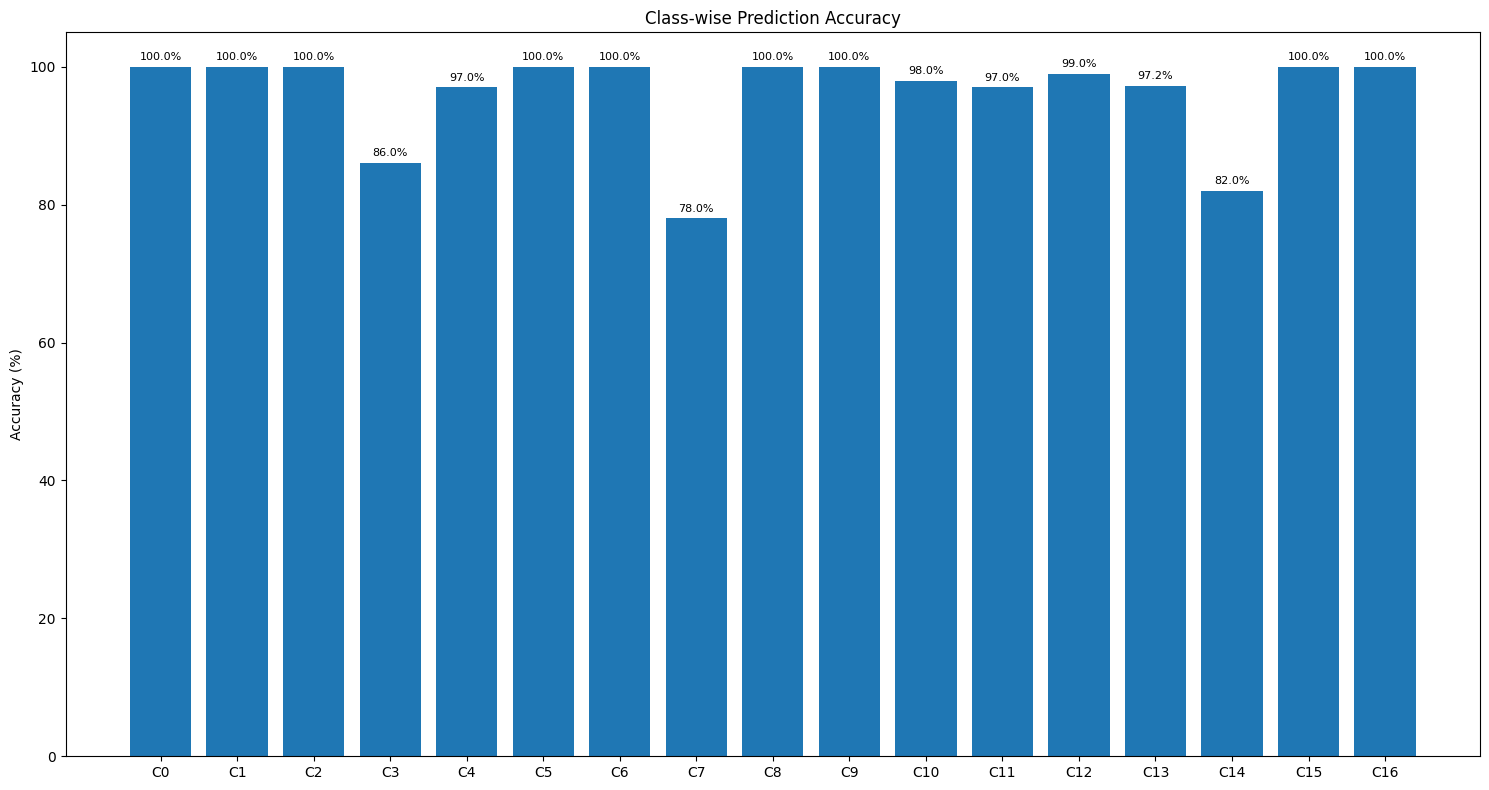

Worst 3 classes:
Class 7: 78.0%
Class 14: 82.0%
Class 3: 86.0%


In [12]:
# 클래스별 성능 시각화
meta_df = pd.read_csv("../data/meta.csv")
avg_acc = {c: np.mean([f.get(c,0) for f in fold_class_accuracies]) for c in range(17)}

plt.figure(figsize=(15, 8))
classes = list(avg_acc.keys())
accs = [avg_acc[c] * 100 for c in classes]
names = [f"C{c}" for c in classes]

plt.bar(range(17), accs)
plt.xticks(range(17), names)
plt.ylabel('Accuracy (%)')
plt.title('Class-wise Prediction Accuracy')
for i, acc in enumerate(accs):
    plt.text(i, acc + 1, f'{acc:.1f}%', ha='center', fontsize=8)
plt.tight_layout()
plt.show()

print("Worst 3 classes:")
worst = sorted(avg_acc.items(), key=lambda x: x[1])[:3]
for c, acc in worst:
    print(f"Class {c}: {acc*100:.1f}%")

In [13]:
# 5-Fold 앙상블 모델 준비
ensemble_models = []
for i, state_dict in enumerate(fold_models):
    fold_model = timm.create_model(model_name, pretrained=True, num_classes=17).to(device)
    fold_model.load_state_dict(state_dict)
    fold_model.eval()
    ensemble_models.append(fold_model)
print(f"Using ensemble of all {len(ensemble_models)} fold models for inference")

Using ensemble of all 5 fold models for inference


## 5. Train Model
* 모델을 로드하고, 학습을 진행합니다.

# 6. Inference & Save File
* 테스트 이미지에 대한 추론을 진행하고, 결과 파일을 저장합니다.

In [14]:
# Temperature Scaling 클래스 정의
class TemperatureScaling(nn.Module):
    def __init__(self):
        super().__init__()
        self.temperature = nn.Parameter(torch.ones(1) * 1.5)
    
    def forward(self, logits):
        return logits / self.temperature

In [15]:
essential_tta_transforms = [
    # 원본
    A.Compose([
        A.LongestMaxSize(max_size=img_size),
        A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]),
    # 90도 회전들
    A.Compose([
        A.LongestMaxSize(max_size=img_size),
        A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
        A.Rotate(limit=[90, 90], p=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]),
    A.Compose([
        A.LongestMaxSize(max_size=img_size),
        A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
        A.Rotate(limit=[180, 180], p=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]),
    A.Compose([
        A.LongestMaxSize(max_size=img_size),
        A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
        A.Rotate(limit=[-90, -90], p=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]),
    # 밝기 개선
    A.Compose([
        A.LongestMaxSize(max_size=img_size),
        A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
        A.RandomBrightnessContrast(brightness_limit=[0.3, 0.3], contrast_limit=[0.3, 0.3], p=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]),
]

In [16]:
# TTA 추론을 위한 Dataset 클래스
class TTAImageDataset(Dataset):
    def __init__(self, data, path, transforms):
        if isinstance(data, str):
            self.df = pd.read_csv(data).values
        else:
            self.df = data.values
        self.path = path
        self.transforms = transforms  # 여러 transform을 리스트로 받음

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)).convert('RGB'))
        
        # 모든 transform을 적용한 결과를 리스트로 반환
        augmented_images = []
        for transform in self.transforms:
            aug_img = transform(image=img)['image']
            augmented_images.append(aug_img)
        
        return augmented_images, target

In [17]:
# TTA Dataset 생성
tta_dataset = TTAImageDataset(
    "../data/sample_submission.csv",
    "../data/test/",
    essential_tta_transforms
)

# TTA DataLoader (배치 크기를 줄여서 메모리 절약)
tta_loader = DataLoader(
    tta_dataset,
    batch_size=64,  # TTA는 메모리를 많이 사용하므로 배치 크기 줄임
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

print(f"TTA Dataset size: {len(tta_dataset)}")

TTA Dataset size: 3140


In [18]:
def ensemble_tta_inference(models, loader, transforms, confidence_threshold=0.9):
    """5-Fold 모델 앙상블 + TTA 추론"""
    all_predictions = []
    
    for batch_idx, (images_list, _) in enumerate(tqdm(loader, desc="Ensemble TTA")):
        batch_size = images_list[0].size(0)
        ensemble_probs = torch.zeros(batch_size, 17).to(device)
        
        # 각 fold 모델별 예측
        for model in models:
            with torch.no_grad():
                # 각 TTA 변형별 예측
                for images in images_list:
                    images = images.to(device)
                    preds = model(images)
                    probs = torch.softmax(preds, dim=1)
                    ensemble_probs += probs / (len(models) * len(images_list))
        
        final_preds = torch.argmax(ensemble_probs, dim=1)
        all_predictions.extend(final_preds.cpu().numpy())
    
    return all_predictions

In [19]:
# 앙상블 TTA 실행
print("Starting Ensemble TTA inference...")
tta_predictions = ensemble_tta_inference(
    models=ensemble_models, 
    loader=tta_loader, 
    transforms=essential_tta_transforms,
    confidence_threshold=0.9
)

Starting Ensemble TTA inference...


Ensemble TTA: 100%|██████████| 50/50 [12:38<00:00, 15.16s/it]


In [20]:
# TTA 결과로 submission 파일 생성
tta_pred_df = pd.DataFrame(tta_dataset.df, columns=['ID', 'target'])
tta_pred_df['target'] = tta_predictions

In [21]:
# 기존 submission과 동일한 순서인지 확인
sample_submission_df = pd.read_csv("../data/sample_submission.csv")
assert (sample_submission_df['ID'] == tta_pred_df['ID']).all()

In [22]:
# TTA 결과 저장
tta_pred_df.to_csv("../submission/choice.csv", index=False)
print("TTA predictions saved")

print("TTA Prediction sample:")

TTA predictions saved
TTA Prediction sample:


In [23]:
tta_pred_df.head()

,ID,target
0,0008fdb22ddce0ce.jpg,2
1,00091bffdffd83de.jpg,12
2,00396fbc1f6cc21d.jpg,5
3,00471f8038d9c4b6.jpg,12
4,00901f504008d884.jpg,2
